<a href="https://colab.research.google.com/github/fedeStaffo/DataScience/blob/main/clustering_uk_roads_accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Assicurati che la libreria Kaggle sia installata
!pip install kaggle

# Scarica il dataset
!kaggle datasets download -d tsiaras/uk-road-safety-accidents-and-vehicles

# Estrai il contenuto
!unzip uk-road-safety-accidents-and-vehicles.zip -d /content/dataset

Dataset URL: https://www.kaggle.com/datasets/tsiaras/uk-road-safety-accidents-and-vehicles
License(s): DbCL-1.0
uk-road-safety-accidents-and-vehicles.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  uk-road-safety-accidents-and-vehicles.zip
replace /content/dataset/Accident_Information.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Vehicle_Information.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd
import os

# Controlla i file nella directory del dataset
print(os.listdir('/content/dataset/'))  # Verifica i nomi dei file

# Caricamento del dataset sugli incidenti e rimozione delle colonne non necessarie
accidents_df = pd.read_csv('/content/dataset/Accident_Information.csv') \
    .drop(columns=['InScotland', 'Police_Force', 'LSOA_of_Accident_Location',
                   'Location_Easting_OSGR', 'Location_Northing_OSGR'])

# Caricamento del dataset sui veicoli e rimozione delle colonne non necessarie
vehicles_df = pd.read_csv('/content/dataset/Vehicle_Information.csv', encoding="ISO-8859-1") \
    .drop(columns=['Vehicle_Location.Restricted_Lane', 'Vehicle_Reference'])

# Estrazione di una data ogni 10 nel dataset degli incidenti
accidents_df['Date'] = pd.to_datetime(accidents_df['Date'])
accidents_df.sort_values(by='Date', inplace=True)
accidents_df = accidents_df.iloc[::10, :]

# Rimozione degli incidenti senza informazioni sui veicoli tramite una inner join
# Nota: data la possibile presenza di più veicoli in un incidente, vengono rimossi i duplicati prima di eseguire il merge
incidents_in_vehicle_df = vehicles_df[['Accident_Index']].drop_duplicates(subset='Accident_Index')
accidents_df = pd.merge(accidents_df, incidents_in_vehicle_df, on='Accident_Index', how='inner')

# Salvataggio del dataset degli incidenti ripulito in un file CSV
accidents_df.to_csv('/content/dataset/accident_etl.csv', index=False)

# Rimozione dei veicoli non associati ad alcun incidente nel primo dataset mediante una inner join
vehicles_df = pd.merge(accidents_df[['Accident_Index']], vehicles_df, on='Accident_Index', how='inner')

# Salvataggio del dataset dei veicoli ripulito in un file CSV
vehicles_df.to_csv('/content/dataset/vehicle_etl.csv', index=False)

# Conferma dell'ETL completato
print("ETL completato! I file ripuliti sono stati salvati come 'accident_etl.csv' e 'vehicle_etl.csv'.")


['vehicle_etl.csv', 'accident_etl.csv', 'Accident_Information.csv', 'Vehicle_Information.csv']


<ipython-input-1-189d929f5dd1>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_df = pd.read_csv('/content/dataset/Accident_Information.csv') \


ETL completato! I file ripuliti sono stati salvati come 'accident_etl.csv' e 'vehicle_etl.csv'.


# Clustering preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Caricamento dei dataset ripuliti
try:
    accidents_df = pd.read_csv('/content/dataset/accident_etl.csv')
    vehicles_df = pd.read_csv('/content/dataset/vehicle_etl.csv')
except Exception as e:
    print(f"Errore nel caricamento dei dataset: {e}")
    exit()

# Unione dei dataset sulla colonna Accident_Index
print("Unendo i dataset...")
combined_df = pd.merge(accidents_df, vehicles_df, on='Accident_Index', how='inner')
print("Colonne disponibili nel dataset combinato dopo la fusione:")
print(combined_df.columns)

# Rimozione delle colonne irrilevanti tramite feature selection
columns_to_drop = [
    '1st_Road_Number', '2nd_Road_Number', 'Date',
    'Did_Police_Officer_Attend_Scene_of_Accident', 'Junction_Control',
    'Junction_Detail', 'Latitude', 'Local_Authority_(District)',
    'Local_Authority_(Highway)', 'Longitude', 'Special_Conditions_at_Site',
    'Year_x', 'Journey_Purpose_of_Driver', 'Junction_Location', 'make', 'model',
    'Propulsion_Code', 'Sex_of_Driver', 'Skidding_and_Overturning',
    'Towing_and_Articulation', 'Vehicle_Leaving_Carriageway',
    'Was_Vehicle_Left_Hand_Drive', 'X1st_Point_of_Impact', 'Year_y'
]

# Rimuovere le colonne selezionate
combined_df_reduced = combined_df.drop(columns=columns_to_drop)
print("Colonne disponibili nel dataset combinato dopo la rimozione delle colonne irrilevanti:")
print(combined_df_reduced.columns)

# Filtra le colonne numeriche
numeric_features = combined_df_reduced.select_dtypes(include=[np.number])
print("Colonne numeriche disponibili:")
print(numeric_features.columns)

# Controllo di valori NaN o Inf
print("Verifica di NaN e Inf...")
if numeric_features.isnull().any().any() or not np.isfinite(numeric_features).all().all():
    print("Il dataset contiene NaN o Inf. Risoluzione in corso...")

    # Utilizza la mediana per sostituire i valori NaN o Inf
    imputer = SimpleImputer(strategy='median')
    numeric_features = pd.DataFrame(imputer.fit_transform(numeric_features), columns=numeric_features.columns)

print("Colonne numeriche disponibili dopo l'imputazione dei valori mancanti:")
print(numeric_features.columns)

Unendo i dataset...
Colonne disponibili nel dataset combinato dopo la fusione:
Index(['Accident_Index', '1st_Road_Class', '1st_Road_Number', '2nd_Road_Class',
       '2nd_Road_Number', 'Accident_Severity', 'Carriageway_Hazards', 'Date',
       'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Local_Authority_(Highway)', 'Longitude',
       'Number_of_Casualties', 'Number_of_Vehicles',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions',
       'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Time',
       'Urban_or_Rural_Area', 'Weather_Conditions', 'Year_x',
       'Age_Band_of_Driver', 'Age_of_Vehicle', 'Driver_Home_Area_Type',
       'Driver_IMD_Decile', 'Engine_Capacity_.CC.',
       'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
       'Journey_Purpose_of_Driver', 'J

# 1. Clustering Bidimensionale

Le due feature con la correlazione più alta sono: Number_of_Vehicles e Number_of_Casualties


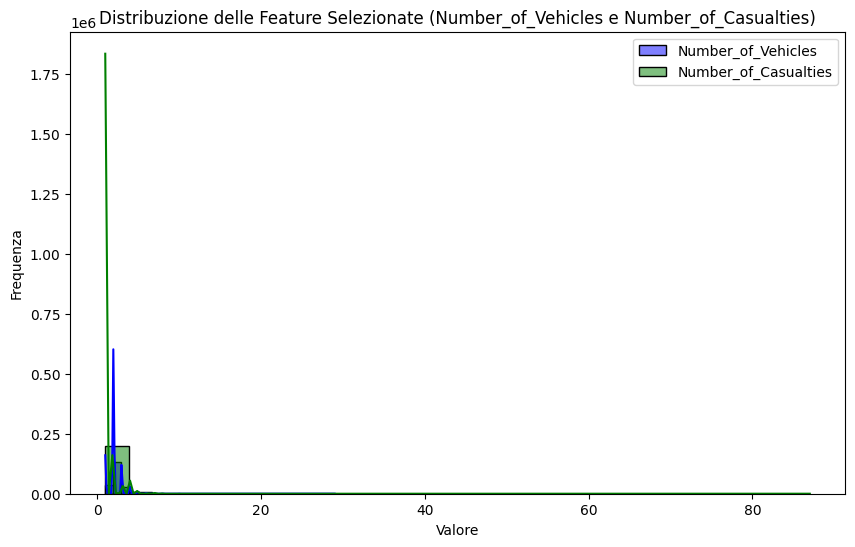

In [ ]:
# Trova la coppia di feature con la correlazione più alta (escludendo la diagonale)
correlation_values = correlation_matrix.unstack().sort_values(ascending=False)
selected_pairs = correlation_values[correlation_values < 1.0]  # Escludere la correlazione perfetta
top_pair = selected_pairs.idxmax()  # Coppia con la correlazione più alta

# Visualizza la coppia selezionata
feature_1, feature_2 = top_pair
print(f"Le due feature con la correlazione più alta sono: {feature_1} e {feature_2}")

# Plot della distribuzione delle feature selezionate
plt.figure(figsize=(10, 6))
sns.histplot(numeric_features[feature_1], kde=True, color='blue', label=feature_1, bins=30)
sns.histplot(numeric_features[feature_2], kde=True, color='green', label=feature_2, bins=30)

# Miglioramenti del grafico
plt.title(f'Distribuzione delle Feature Selezionate ({feature_1} e {feature_2})')
plt.xlabel('Valore')
plt.ylabel('Frequenza')
plt.legend()
plt.show()

Link: [Elbow method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/#understanding-distortion-and-inertia-in-kmeans-clustering)

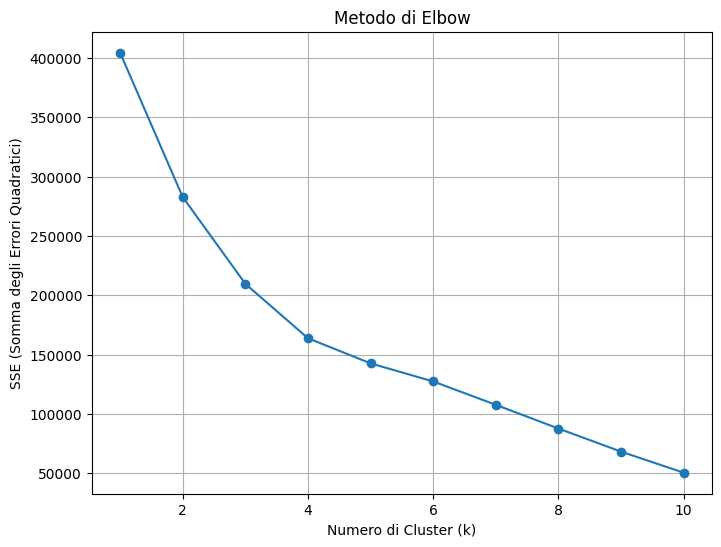

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Dataset per clustering
clustering_data = numeric_features[[feature_1, feature_2]].dropna()

# Metodo di Elbow
sse = []
k_range = range(1, 11)  # Prova per k da 1 a 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    sse.append(kmeans.inertia_)

# Plot del Metodo di Elbow
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.title("Metodo di Elbow")
plt.xlabel("Numero di Cluster (k)")
plt.ylabel("SSE (Somma degli Errori Quadratici)")
plt.grid(True)
plt.show()

# Scegli il k


Indice di Silhouette per K-Means con k=4: 0.57


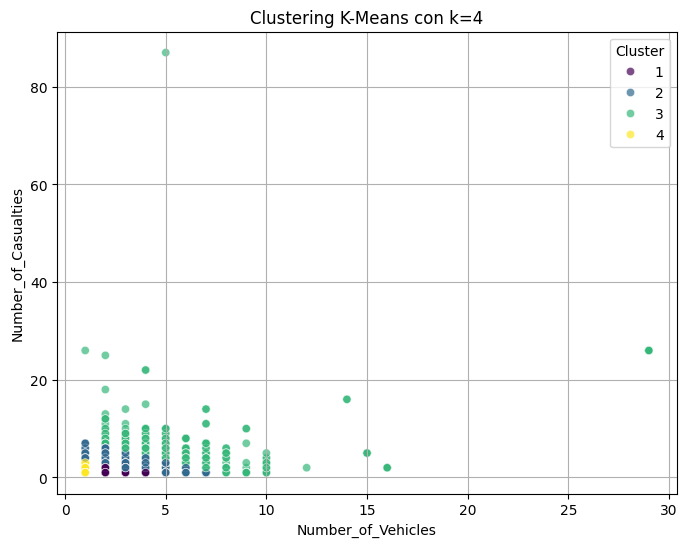

Medie delle feature per ciascun cluster:
               Number_of_Vehicles  Number_of_Casualties
kmeans_labels                                          
1                        2.160874              1.175030
2                        2.961384              2.831643
3                        5.719931              5.757732
4                        1.000000              1.122300


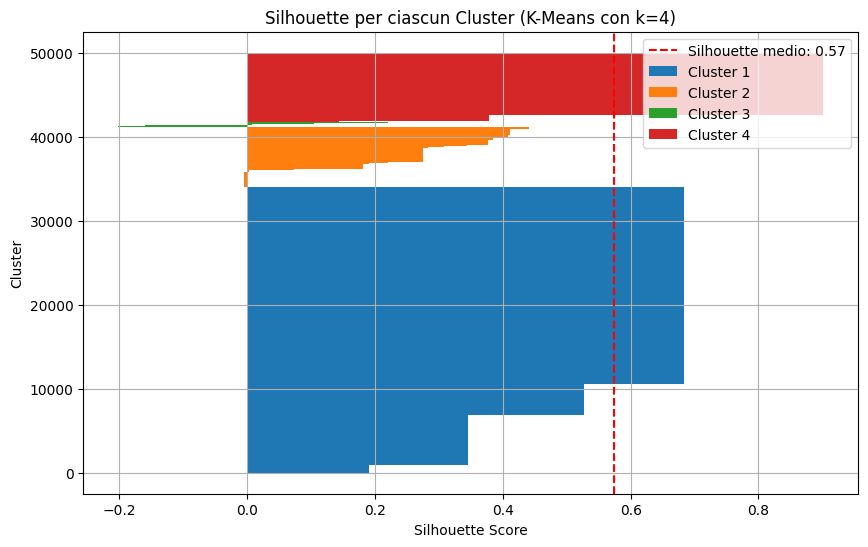

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample

# Seleziona le feature per il clustering
features = clustering_data[[feature_1, feature_2]]

# Selezioniamo al massimo 50.000 campioni
max_samples = 50000
if len(features) > max_samples:
    clustering_data_sampled = resample(clustering_data, n_samples=max_samples, random_state=42)
    features = clustering_data_sampled[[feature_1, feature_2]]
else:
    clustering_data_sampled = clustering_data

# Scegliere il k dal grafico
chosen_k = 4

# Applicazione del K-Means con k scelto
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
clustering_data_sampled['kmeans_labels'] = kmeans.fit_predict(features)

# Modifica le etichette dei cluster per iniziare da 1 invece di 0
clustering_data_sampled['kmeans_labels'] += 1

# Calcolo della silhouette per K-Means
silhouette_avg = silhouette_score(features, clustering_data_sampled['kmeans_labels'])
print(f"Indice di Silhouette per K-Means con k={chosen_k}: {silhouette_avg:.2f}")

# Calcolo della silhouette per ogni campione
silhouette_values = silhouette_samples(features, clustering_data_sampled['kmeans_labels'])

# 1. Visualizzazione del clustering K-Means con etichette cluster da 1 a k
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=clustering_data_sampled[feature_1],
    y=clustering_data_sampled[feature_2],
    hue="kmeans_labels",
    palette="viridis",  # I colori rimarranno coerenti con quelli nel grafico della silhouette
    data=clustering_data_sampled,
    alpha=0.7
)
plt.title(f"Clustering K-Means con k={chosen_k}")
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# 2. Calcolo delle medie delle feature per ciascun cluster
cluster_summary = clustering_data_sampled.groupby('kmeans_labels')[[f'{feature_1}', f'{feature_2}']].mean()
print("Medie delle feature per ciascun cluster:")
print(cluster_summary)

# 3. Plot della silhouette per ogni punto
plt.figure(figsize=(10, 6))

y_lower, y_upper = 0, 0
for i in range(chosen_k):
    # Ottieni i valori della silhouette per il cluster
    cluster_silhouette_values = silhouette_values[clustering_data_sampled['kmeans_labels'] == i+1]
    cluster_silhouette_values.sort()

    # Aggiorna gli spazi tra i cluster
    y_upper += len(cluster_silhouette_values)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_values, height=1.0, edgecolor='none', label=f"Cluster {i+1}")
    y_lower += len(cluster_silhouette_values)

# Linea verticale tratteggiata per il valore medio di silhouette
plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Silhouette medio: {silhouette_avg:.2f}")

# Modifiche al plot
plt.title(f"Silhouette per ciascun Cluster (K-Means con k={chosen_k})")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster")
plt.legend(loc="upper right")  # Impostiamo una posizione esplicita per la legenda
plt.grid(True)
plt.show()


# 2. Clustering Multidimensionale con PCA

Unendo i dataset...
Colonne disponibili nel dataset combinato dopo la fusione:
Index(['Accident_Index', '1st_Road_Class', '1st_Road_Number', '2nd_Road_Class',
       '2nd_Road_Number', 'Accident_Severity', 'Carriageway_Hazards', 'Date',
       'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Local_Authority_(Highway)', 'Longitude',
       'Number_of_Casualties', 'Number_of_Vehicles',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions',
       'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Time',
       'Urban_or_Rural_Area', 'Weather_Conditions', 'Year_x',
       'Age_Band_of_Driver', 'Age_of_Vehicle', 'Driver_Home_Area_Type',
       'Driver_IMD_Decile', 'Engine_Capacity_.CC.',
       'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
       'Journey_Purpose_of_Driver', 'J

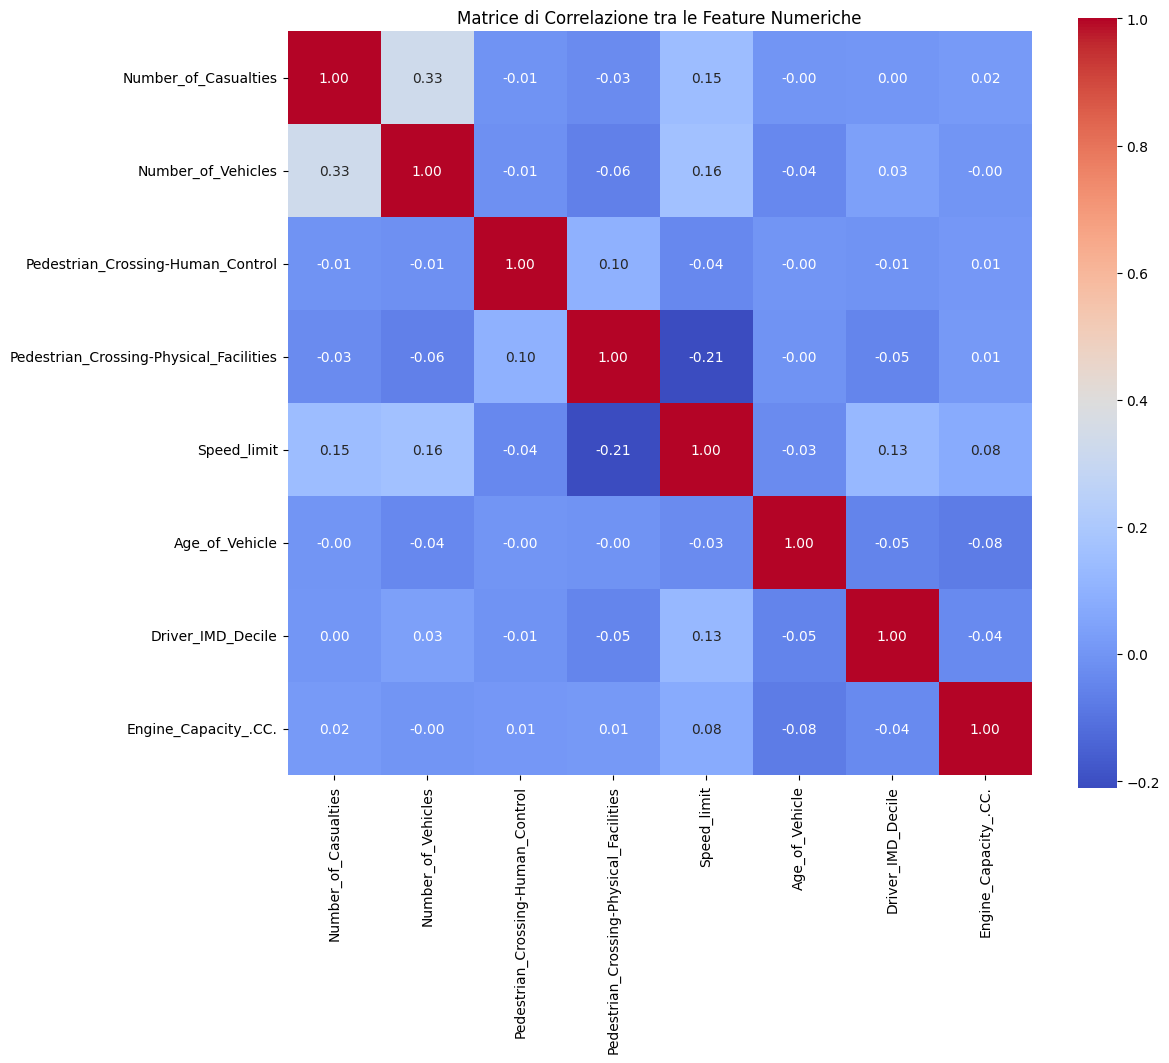

Feature numeriche standardizzate.


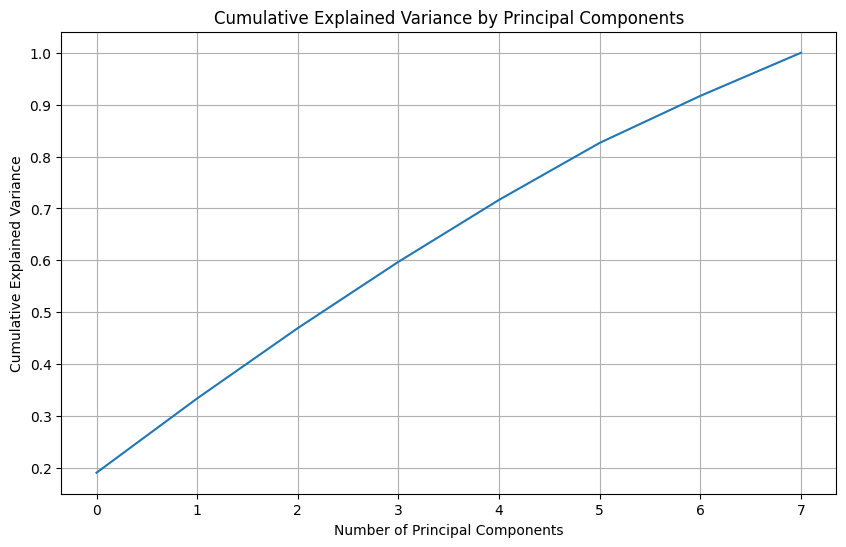

Numero di componenti principali da mantenere: 7
Colonne disponibili nel dataset dopo PCA:
Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'Accident_Index'], dtype='object')
Calcolando la matrice di correlazione tra i componenti principali...


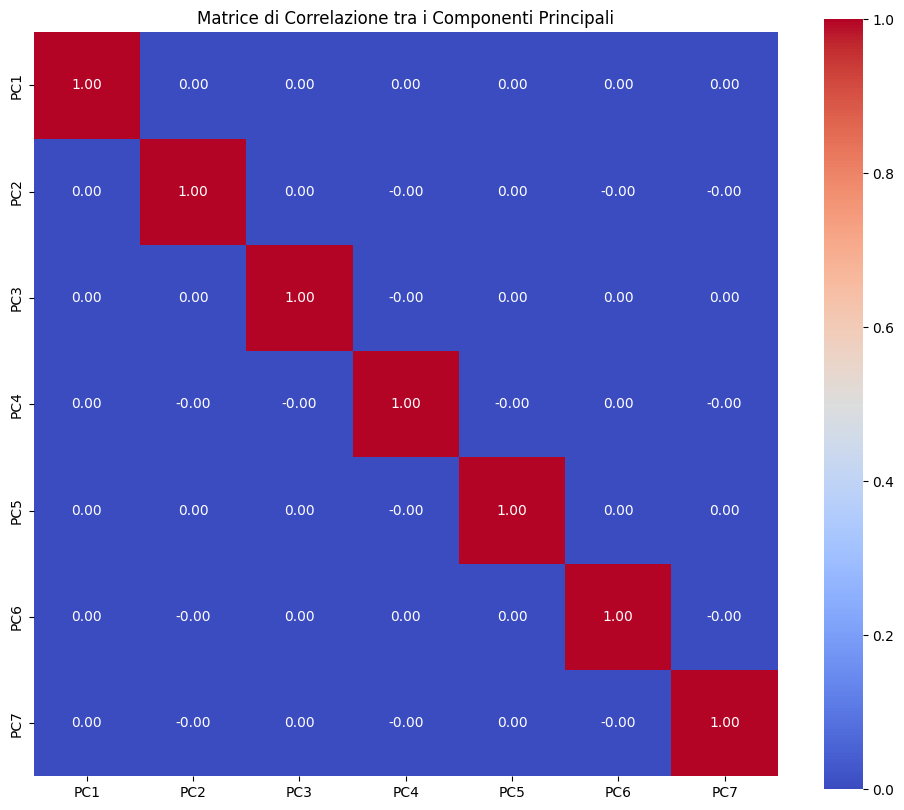

Carichi fattoriali (loadings):
                                              PC1       PC2       PC3  \
Number_of_Casualties                     0.505513  0.462970  0.134777   
Number_of_Vehicles                       0.541429  0.378361  0.101364   
Pedestrian_Crossing-Human_Control       -0.122879  0.390574 -0.231035   
Pedestrian_Crossing-Physical_Facilities -0.334324  0.535118 -0.165589   
Speed_limit                              0.517859 -0.276977 -0.099506   
Age_of_Vehicle                          -0.102049  0.024846  0.672716   
Driver_IMD_Decile                        0.197244 -0.352772 -0.172248   
Engine_Capacity_.CC.                     0.083321  0.042674 -0.631384   

                                              PC4       PC5       PC6  \
Number_of_Casualties                    -0.031214 -0.082016  0.086931   
Number_of_Vehicles                       0.045908 -0.148677 -0.021782   
Pedestrian_Crossing-Human_Control        0.439730  0.663087 -0.371639   
Pedestrian_Crossing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Caricamento dei dataset ripuliti
try:
    accidents_df = pd.read_csv('/content/dataset/accident_etl.csv')
    vehicles_df = pd.read_csv('/content/dataset/vehicle_etl.csv')
except Exception as e:
    print(f"Errore nel caricamento dei dataset: {e}")
    exit()

# Unione dei dataset sulla colonna Accident_Index
print("Unendo i dataset...")
combined_df = pd.merge(accidents_df, vehicles_df, on='Accident_Index', how='inner')
print("Colonne disponibili nel dataset combinato dopo la fusione:")
print(combined_df.columns)

# Rimozione delle colonne irrilevanti tramite feature selection
columns_to_drop = [
    '1st_Road_Number', '2nd_Road_Number', 'Date',
    'Did_Police_Officer_Attend_Scene_of_Accident', 'Junction_Control',
    'Junction_Detail', 'Latitude', 'Local_Authority_(District)',
    'Local_Authority_(Highway)', 'Longitude', 'Special_Conditions_at_Site',
    'Year_x', 'Journey_Purpose_of_Driver', 'Junction_Location', 'make', 'model',
    'Propulsion_Code', 'Sex_of_Driver', 'Skidding_and_Overturning',
    'Towing_and_Articulation', 'Vehicle_Leaving_Carriageway',
    'Was_Vehicle_Left_Hand_Drive', 'X1st_Point_of_Impact', 'Year_y'
]

# Rimuovere le colonne selezionate
combined_df_reduced = combined_df.drop(columns=columns_to_drop)
print("Colonne disponibili nel dataset combinato dopo la rimozione delle colonne irrilevanti:")
print(combined_df_reduced.columns)

# Filtra le colonne numeriche
numeric_features = combined_df_reduced.select_dtypes(include=[np.number])
print("Colonne numeriche disponibili:")
print(numeric_features.columns)

# Controllo di valori NaN o Inf
print("Verifica di NaN e Inf...")
if numeric_features.isnull().any().any() or not np.isfinite(numeric_features).all().all():
    print("Il dataset contiene NaN o Inf. Risoluzione in corso...")

    # Utilizza la mediana per sostituire i valori NaN o Inf
    imputer = SimpleImputer(strategy='median')
    numeric_features = pd.DataFrame(imputer.fit_transform(numeric_features), columns=numeric_features.columns)

print("Colonne numeriche disponibili dopo l'imputazione dei valori mancanti:")
print(numeric_features.columns)

# Matrice di correlazione prima della PCA
print("Calcolando la matrice di correlazione delle feature numeriche prima della PCA...")
correlation_matrix_original = numeric_features.corr()

# Plot della matrice di correlazione originale
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_original, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Matrice di Correlazione tra le Feature Numeriche')
plt.show()

# Standardizzazione delle feature numeriche
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)
print("Feature numeriche standardizzate.")

# Applicare la PCA
pca = PCA()
pca.fit(numeric_features_scaled)

# Somma delle varianze spiegate
explained_variance_ratio = pca.explained_variance_ratio_

# Plot della varianza spiegata
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determina quante componenti principali spiegano almeno il 90% della varianza
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_to_keep = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Numero di componenti principali da mantenere: {n_components_to_keep}")

# Ridurre la dimensionalità a n_components_to_keep
pca = PCA(n_components=n_components_to_keep)
principal_components = pca.fit_transform(numeric_features_scaled)

# Crea un DataFrame con i componenti principali
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components_to_keep)])

# Aggiungi l'Indice dell'Accidente
pca_df['Accident_Index'] = combined_df_reduced['Accident_Index'].values
print("Colonne disponibili nel dataset dopo PCA:")
print(pca_df.columns)

# Calcolo della matrice di correlazione delle feature dopo la PCA
print("Calcolando la matrice di correlazione tra i componenti principali...")
correlation_matrix_pca = pca_df.drop(columns=['Accident_Index']).corr()

# Plot della matrice di correlazione dei componenti principali
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_pca, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Matrice di Correlazione tra i Componenti Principali')
plt.show()

# Matrice dei carichi fattoriali
loadings = pd.DataFrame(
    data=pca.components_.T,  # Trasposta per avere feature come righe
    columns=[f'PC{i+1}' for i in range(n_components_to_keep)],  # Nomi delle componenti
    index=numeric_features.columns  # Nomi delle feature originali
)

# Mostra i primi 5 carichi per ogni componente
print("Carichi fattoriali (loadings):")
print(loadings)

# Identifica le feature più importanti per ogni componente
for i in range(n_components_to_keep):
    print(f"\nFeature più influenti per PC{i+1}:")
    print(loadings.iloc[:, i].sort_values(ascending=False).head(5))


### Significato di **PC1** e **PC2**:
- **PC1 (Prima Componente Principale)** rappresenta la direzione in cui i dati hanno la maggiore varianza. Le variabili che contribuiscono di più a PC1 (in ordine decrescente di importanza) sono:
  - **Number_of_Vehicles (0.541429)**: Più veicoli per incidente, più il dato contribuirà a questa componente.
  - **Speed_limit (0.517859)**: I limiti di velocità sono anche importanti per PC1.
  - **Number_of_Casualties (0.505513)**: Il numero di vittime in un incidente ha una correlazione positiva con PC1.
  - Altre variabili come **Driver_IMD_Decile** e **Engine_Capacity_.CC.** contribuiscono in misura minore.
  
  La combinazione di queste variabili indica che PC1 cattura principalmente la variabilità associata alla gravità dell'incidente, al numero di veicoli coinvolti e alla severità del limite di velocità.

- **PC2 (Seconda Componente Principale)** ha una direzione ortogonale rispetto a PC1, quindi cattura la varianza che non è stata catturata dalla prima componente. Le variabili più influenti per PC2 sono:
  - **Pedestrian_Crossing-Physical_Facilities (0.535118)**: La presenza di strutture di attraversamento pedonale è una delle variabili più forti in questa componente.
  - **Number_of_Casualties (0.462970)**: Il numero di vittime continua ad avere un impatto anche su questa componente.
  - **Pedestrian_Crossing-Human_Control (0.390574)**: La presenza di controlli umani su attraversamenti pedonali è anch'essa influente.
  - Anche in questo caso, **Number_of_Vehicles** ha un contributo significativo.

  PC2 sembra quindi catturare la variabilità legata alle condizioni di attraversamento pedonale, sia fisiche che umane, e a come queste si relazionano al numero di vittime e al tipo di incidente.

### Interpretazione del Clustering con PC1 e PC2:
Quando esegui il clustering usando PC1 e PC2, stai essenzialmente cercando di raggruppare gli incidenti basandoti su una combinazione di fattori legati alla gravità dell'incidente, al numero di veicoli coinvolti, alle condizioni stradali, e alla gestione dell'attraversamento pedonale. Questi gruppi (cluster) possono rappresentare, ad esempio:
- **Cluster 1**: Incidenti con molti veicoli e alta gravità, possibilmente in aree urbane con limiti di velocità elevati.
- **Cluster 2**: Incidenti con minori veicoli ma con alta mortalità, forse in condizioni stradali particolari o in aree con scarsa visibilità.
- **Cluster 3**: Incidenti con presenza significativa di pedoni o condizioni di attraversamento pedonale, che possono differire da altri cluster per la loro gestione della sicurezza pedonale.

### Significato delle altre componenti principali:
- **PC3**: Rappresenta variabili come l'età del veicolo e il numero di vittime. Potrebbe riflettere la gravità o il tipo di veicolo coinvolto nell'incidente, con gli incidenti più gravi legati a veicoli più vecchi.
- **PC4**: Si concentra su variabili come il decile IMD del conducente (indicatore di deprivazione) e la gestione degli attraversamenti pedonali. Potrebbe indicare che alcune zone o gruppi socioeconomici sono più inclini a determinati tipi di incidenti.
- **PC5, PC6, PC7**: Queste componenti captano altre variazioni più specifiche, come l'interazione tra il tipo di veicolo e le condizioni stradali, l'età del conducente e le condizioni ambientali come il traffico o la visibilità.

In sintesi, il clustering basato su PC1 e PC2 ti permette di identificare gruppi di incidenti che condividono caratteristiche simili, come il numero di veicoli coinvolti, la gravità, le condizioni pedonali, e altri fattori. Le componenti principali ti danno un'idea di come le variabili originali interagiscono tra loro per influenzare la tipologia degli incidenti.

## DBSCAN con metodo del gomito

Calcolando le distanze dei vicini più prossimi...


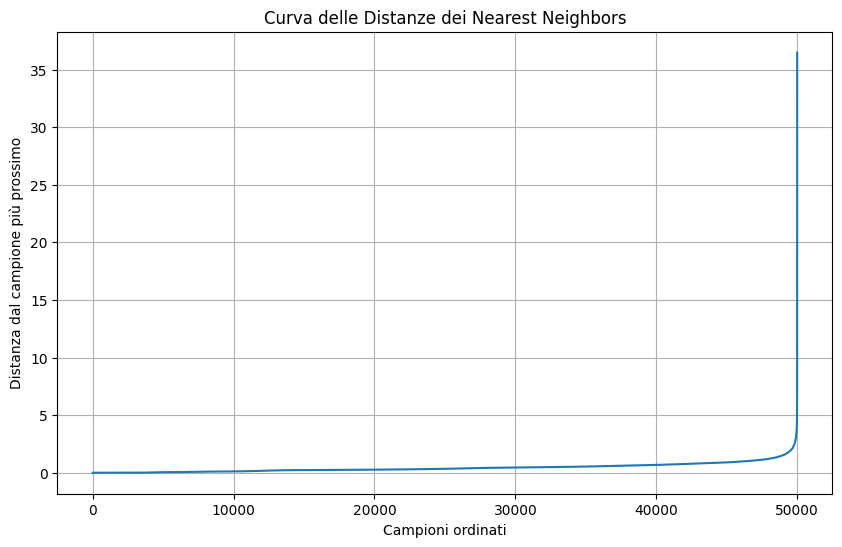

Valore scelto di epsilon (eps): 1.1292665066844687
Numero di min_samples scelto: 18
Eseguendo il clustering con DBSCAN...
Numero di cluster trovati da DBSCAN: 7
Silhouette Score per DBSCAN: 0.339


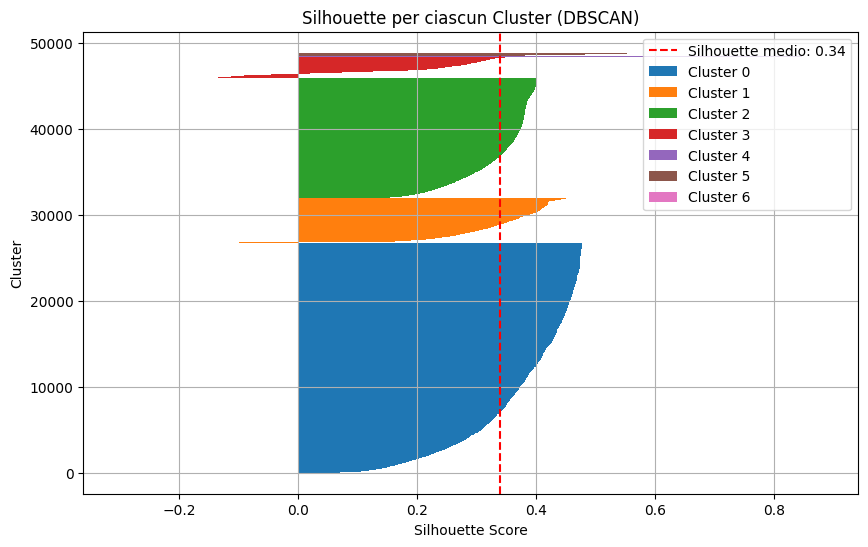

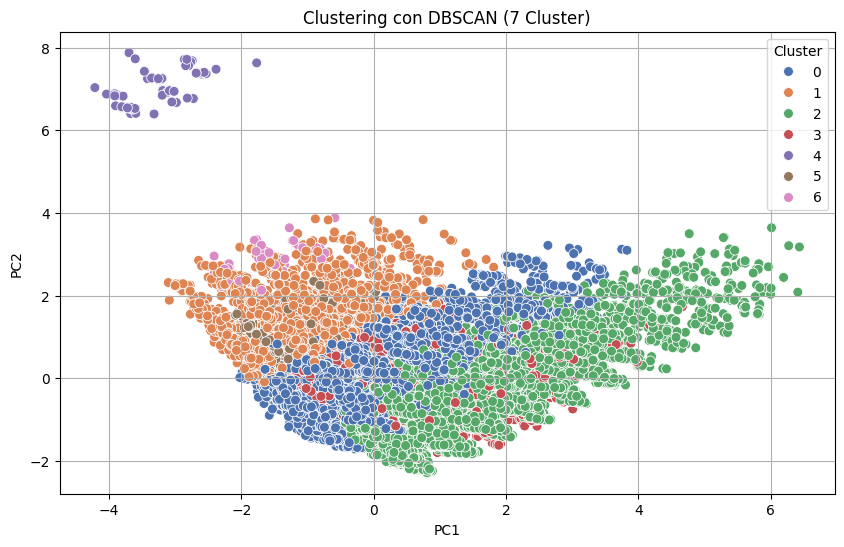

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.preprocessing import StandardScaler

# Selezionare le feature per il clustering (dopo PCA)
X = pca_df.drop(columns=['Accident_Index']).values

# Esegui il campionamento
sample_size = 50000  # Numero di campioni da utilizzare per il clustering
X_sampled = X[:sample_size]  # Usa solo i primi n campioni

# Normalizzare i dati campionati
scaler = StandardScaler()
X_sampled_scaled = scaler.fit_transform(X_sampled)

# Calcolare il numero di feature per il calcolo di min_samples
n_features = X_sampled_scaled.shape[1]
min_samples = 2 * n_features  # Scegliamo min_samples come il doppio delle feature

# Calcolare la distanza dei k vicini più prossimi
print("Calcolando le distanze dei vicini più prossimi...")
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_sampled_scaled)
distances, indices = neighbors_fit.kneighbors(X_sampled_scaled)

# Ordinare le distanze per visualizzare la curva
distances = np.sort(distances[:, -1], axis=0)

# Plot della curva delle distanze
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Curva delle Distanze dei Nearest Neighbors')
plt.xlabel('Campioni ordinati')
plt.ylabel('Distanza dal campione più prossimo')
plt.grid(True)
plt.show()

# Scegliere automaticamente il valore di epsilon (eps) come il punto di "gomito"
eps = distances[int(0.95 * len(distances))]  # Prendi la distanza al 95° percentile come eps

print(f"Valore scelto di epsilon (eps): {eps}")
print(f"Numero di min_samples scelto: {min_samples}")

# Esegui DBSCAN sui dati campionati
print("Eseguendo il clustering con DBSCAN...")

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_sampled_scaled)

# Numero di cluster trovati
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

# Calcolare il Silhouette Score solo se ci sono più di 1 cluster
silhouette_dbscan = silhouette_score(X_sampled_scaled, dbscan_labels) if n_clusters_dbscan > 1 else None
print(f"Numero di cluster trovati da DBSCAN: {n_clusters_dbscan}")
if silhouette_dbscan:
    print(f"Silhouette Score per DBSCAN: {silhouette_dbscan:.3f}")
else:
    print("Silhouette Score non calcolabile (un solo cluster rilevato).")

# Calcolare il silhouette score per ogni punto
silhouette_values = silhouette_samples(X_sampled_scaled, dbscan_labels)

# Aggiungere i punteggi di silhouette al dataframe
filtered_df = pca_df.iloc[:sample_size].copy()
filtered_df['DBSCAN_Cluster'] = dbscan_labels
filtered_df['Silhouette_Score'] = silhouette_values

# Plot della silhouette per ciascun cluster
plt.figure(figsize=(10, 6))

y_lower, y_upper = 0, 0
for i in range(n_clusters_dbscan):
    # Ottieni i valori della silhouette per il cluster, escludendo il rumore (-1)
    cluster_silhouette_values = silhouette_values[dbscan_labels == i]
    cluster_silhouette_values.sort()

    # Aggiorna gli spazi tra i cluster
    y_upper += len(cluster_silhouette_values)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_values, height=1.0, edgecolor='none', label=f"Cluster {i}")
    y_lower += len(cluster_silhouette_values)

# Linea verticale tratteggiata per il valore medio di silhouette
plt.axvline(x=silhouette_dbscan, color="red", linestyle="--", label=f"Silhouette medio: {silhouette_dbscan:.2f}")

# Modifiche al plot
plt.title(f"Silhouette per ciascun Cluster (DBSCAN)")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster")
plt.legend(loc="upper right")  # Impostiamo una posizione esplicita per la legenda
plt.grid(True)
plt.show()

# Scatter plot con DBSCAN
plt.figure(figsize=(10, 6))

# Visualizza i cluster DBSCAN (escludendo il rumore, che ha label -1)
sns.scatterplot(data=filtered_df[filtered_df['DBSCAN_Cluster'] != -1], x='PC1', y='PC2', hue='DBSCAN_Cluster',
                palette='deep', s=50, legend='full')

plt.title(f'Clustering con DBSCAN ({n_clusters_dbscan} Cluster)')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()


##  K-Means

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler

# Selezionare le feature per il clustering (dopo PCA)
X = pca_df.drop(columns=['Accident_Index']).values

# Esegui il campionamento
sample_size = 50000  # Numero di campioni da utilizzare per il clustering
X_sampled = X[:sample_size]  # Usa solo i primi n campioni

# Normalizzare i dati campionati
scaler = StandardScaler()
X_sampled_scaled = scaler.fit_transform(X_sampled)
print(X_sampled_scalded.shape)

# Metodo del gomito per determinare il numero di cluster ottimale
wcss = []  # Within-cluster sum of squares (WCSS)
max_k = 15  # Proviamo con un numero massimo di cluster
for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_sampled_scaled)
    wcss.append(kmeans.inertia_)

# Plot della curva del gomito
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k+1), wcss)
plt.title('Metodo del Gomito per Determinare il Numero di Cluster')
plt.xlabel('Numero di Cluster')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


NameError: name 'pca_df' is not defined

Numero ottimale di cluster scelto: 5
Silhouette Score per K-Means: 0.307


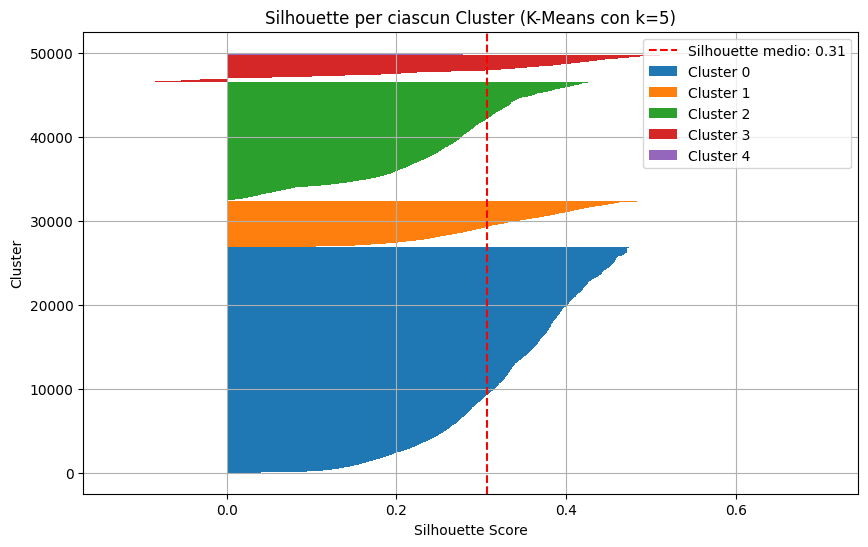

Numero di punti per cluster:
Cluster 0: 26837 punti
Cluster 1: 5506 punti
Cluster 2: 14171 punti
Cluster 3: 3199 punti
Cluster 4: 287 punti


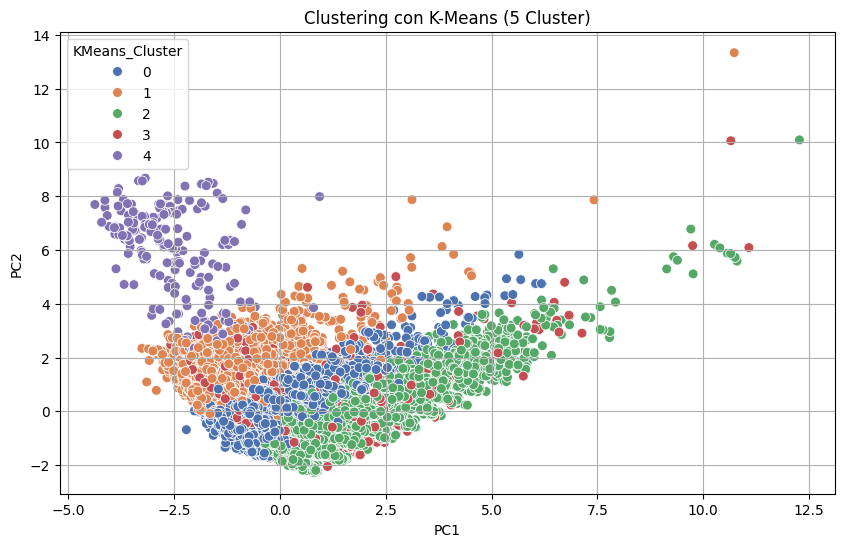

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np

# Determina il numero di cluster ottimale (puoi scegliere un valore visivamente dal grafico)
optimal_k = 5  # Sostituire con il valore scelto visivamente dal grafico

print(f"Numero ottimale di cluster scelto: {optimal_k}")

# Esegui K-Means con il numero di cluster ottimale
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_sampled_scaled)

# Calcolare il Silhouette Score
silhouette_kmeans = silhouette_score(X_sampled_scaled, kmeans_labels)
print(f"Silhouette Score per K-Means: {silhouette_kmeans:.3f}")

# Calcolare il silhouette score per ogni punto
silhouette_values = silhouette_samples(X_sampled_scaled, kmeans_labels)

# Aggiungere i punteggi di silhouette al dataframe
pca_df['KMeans_Cluster'] = -1  # Inizializzazione (cluster non trovato) per tutti i dati
pca_df.iloc[:sample_size, -1] = kmeans_labels  # Assegna i cluster ai dati campionati
pca_df['Silhouette_Score'] = np.nan  # Aggiungi una colonna per il punteggio di silhouette
pca_df.iloc[:sample_size, -1] = silhouette_values  # Assegna i punteggi di silhouette ai campioni

# Plot della silhouette per ciascun cluster
plt.figure(figsize=(10, 6))

y_lower, y_upper = 0, 0
for i in range(optimal_k):
    # Ottieni i valori della silhouette per il cluster
    cluster_silhouette_values = silhouette_values[kmeans_labels == i]
    cluster_silhouette_values.sort()

    # Aggiorna gli spazi tra i cluster
    y_upper += len(cluster_silhouette_values)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_values, height=1.0, edgecolor='none', label=f"Cluster {i}")
    y_lower += len(cluster_silhouette_values)

# Linea verticale tratteggiata per il valore medio di silhouette
plt.axvline(x=silhouette_kmeans, color="red", linestyle="--", label=f"Silhouette medio: {silhouette_kmeans:.2f}")

# Modifiche al plot
plt.title(f"Silhouette per ciascun Cluster (K-Means con k={optimal_k})")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster")
plt.legend(loc="upper right")  # Impostiamo una posizione esplicita per la legenda
plt.grid(True)
plt.show()

# Numero di punti in ciascun cluster
cluster_counts = np.bincount(kmeans_labels)  # Conta i punti in ciascun cluster
print("Numero di punti per cluster:")
for idx, count in enumerate(cluster_counts):
    print(f"Cluster {idx}: {count} punti")

# Scatter plot con K-Means
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df.iloc[:sample_size], x='PC1', y='PC2', hue='KMeans_Cluster', palette='deep', s=50)
plt.title(f'Clustering con K-Means ({optimal_k} Cluster)')
plt.grid(True)
plt.show()
